Epoch 1/200
84/84 [==============================] - 0s 1ms/step - loss: 96045.3203 - mean_absolute_error: 244.1047 - val_loss: 92163.7891 - val_mean_absolute_error: 232.3874
Epoch 2/200
84/84 [==============================] - 0s 698us/step - loss: 68973.5234 - mean_absolute_error: 194.4847 - val_loss: 36196.0312 - val_mean_absolute_error: 128.0969
Epoch 3/200
84/84 [==============================] - 0s 689us/step - loss: 23550.3184 - mean_absolute_error: 107.4001 - val_loss: 20308.8086 - val_mean_absolute_error: 95.0625
Epoch 4/200
84/84 [==============================] - 0s 685us/step - loss: 19097.0840 - mean_absolute_error: 96.9729 - val_loss: 18480.1660 - val_mean_absolute_error: 91.0485
Epoch 5/200
84/84 [==============================] - 0s 687us/step - loss: 18281.5742 - mean_absolute_error: 94.1983 - val_loss: 17561.7734 - val_mean_absolute_error: 88.4562
Epoch 6/200
84/84 [==============================] - 0s 726us/step - loss: 17189.4863 - mean_absolute_error: 91.8250 - val

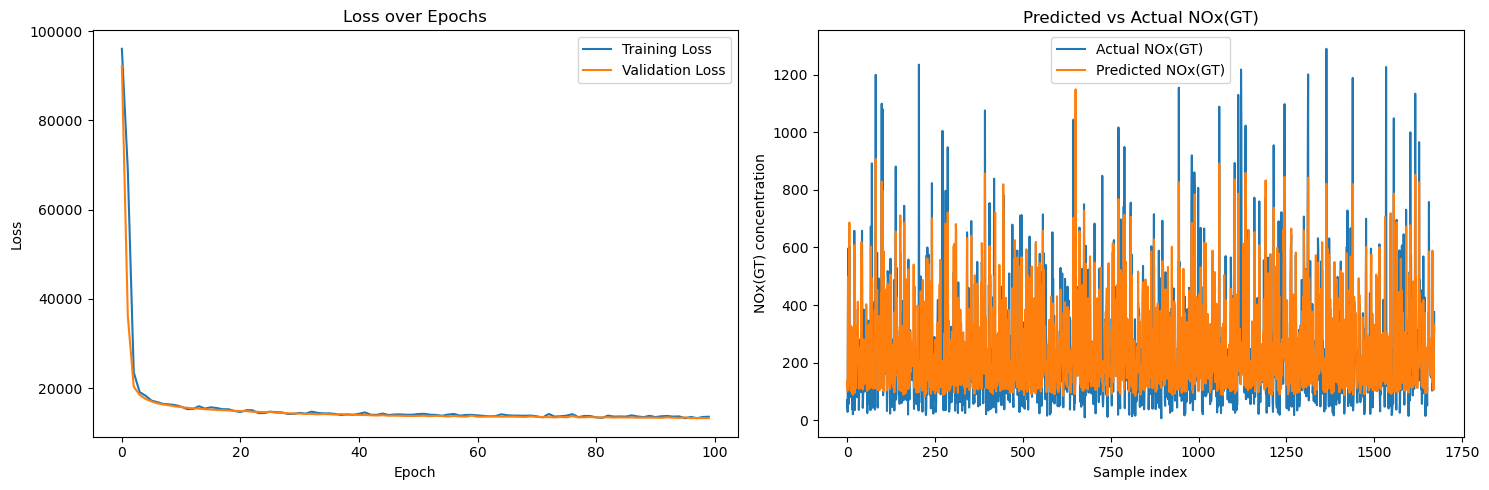

RMSE: 114.48
MAE: 72.55

Performance metrics for the regression task.
     RMSE    MAE  Number of Samples
0  114.48  72.55               1672


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 加载数据
file = 'AirQualityUCI _ Students.xlsx'
data = pd.read_excel(file)

# 将 -200 替换为 NaN
data = data.replace(-200, np.nan)

# 对缺失值较少的列使用均值填充
columns_to_fill = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
for column in columns_to_fill:
    data[column].fillna(data[column].mean(), inplace=True)

# 删除缺失值过多的列
data.drop(columns=['NMHC(GT)'], inplace=True)

# 特征选择和目标变量定义
features = data[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]
target_regression = data['NOx(GT)']

# 数据标准化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 分割数据集
X_train, X_test, y_train_regression, y_test_regression = train_test_split(features_scaled, target_regression, test_size=0.2, random_state=42)

# 设计神经网络
def create_regression_model(input_shape):
    model = Sequential()
    model.add(Dense(128, input_dim=input_shape, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # 回归问题的输出层，不使用激活函数
    return model

input_shape = X_train.shape[1]

# 创建模型
regression_model = create_regression_model(input_shape)

# 编译模型
regression_model.compile(optimizer=Adam(learning_rate=0.0005),
                         loss='mean_squared_error',
                         metrics=['mean_absolute_error'])

# 使用早停法训练模型
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = regression_model.fit(X_train, y_train_regression,
                               epochs=200,
                               batch_size=64,
                               validation_split=0.2,
                               callbacks=[early_stopping])

# 绘制训练过程中的损失曲线和预测值与实际值的对比图
def plot_training_and_prediction(history, y_test, y_pred, epochs=100):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # 绘制损失
    axs[0].plot(history.history['loss'][:epochs], label='Training Loss')
    axs[0].plot(history.history['val_loss'][:epochs], label='Validation Loss')
    axs[0].set_title('Loss over Epochs')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    # 绘制预测值与实际值的对比图
    axs[1].plot(y_test.values, label='Actual NOx(GT)')
    axs[1].plot(y_pred, label='Predicted NOx(GT)')
    axs[1].set_title('Predicted vs Actual NOx(GT)')
    axs[1].set_xlabel('Sample index')
    axs[1].set_ylabel('NOx(GT) concentration')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


# 调用函数，只绘制前100个epochs
y_pred_regression = regression_model.predict(X_test)
plot_training_and_prediction(history, y_test_regression, y_pred_regression, epochs=100)

# 计算性能指标
rmse = np.sqrt(mean_squared_error(y_test_regression, y_pred_regression))
mae = mean_absolute_error(y_test_regression, y_pred_regression)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# 创建DataFrame来表示表格
table = pd.DataFrame({
    'RMSE': [f"{rmse:.2f}"],
    'MAE': [f"{mae:.2f}"],
    'Number of Samples': [len(y_test_regression)]
})

# 打印表格
print("\nPerformance metrics for the regression task.")
print(table)